In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [2]:
# Chargement des fichiers CSV
# Chargement des fichiers CSV
benin_data = pd.read_csv("../../data/Bell_DNS Dataset/features_domain_benign_csv.csv")
malware_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Malware.csv")
phishing_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_phishing.csv")
spam_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Spam.csv")



In [5]:
##################################################################
#################################################################
################## Equilibrer #################################

# Prélèvement d'échantillons pour l'ensemble équilibré

# Échantillons bénins équilibrés : 20,000
benign_balanced_samples = benin_data.sample(20000, random_state=42)
benign_balanced_samples['class'] = 'bengnin'

balanced_spam = spam_data.sample(4337, random_state=42)
balanced_malware = malware_data.sample(4337, random_state=42)
balanced_phishing = phishing_data.sample(4337, random_state=42)

# Concaténation des échantillons équilibrés
malicioux_balanced_samples = pd.concat([balanced_spam, balanced_malware, balanced_phishing],axis=0, ignore_index=True)
malicioux_balanced_samples['class'] = 'malicioux'

balanced_all_data_resampled = pd.concat([malicioux_balanced_samples,benign_balanced_samples],axis=0, ignore_index=True)

print(" Size Malicioux data")
print(malicioux_balanced_samples['class'].value_counts())

print("\n")
print(" Size Bengnin data")
print(benign_balanced_samples['class'].value_counts())

print("\n")
print(" Size all data")
print(balanced_all_data_resampled['class'].value_counts())

print("\n")
print(" Size all data shape")
print(balanced_all_data_resampled.shape)




 Size Malicioux data
class
malicioux    13011
Name: count, dtype: int64


 Size Bengnin data
class
bengnin    20000
Name: count, dtype: int64


 Size all data
class
bengnin      20000
malicioux    13011
Name: count, dtype: int64


 Size all data shape
(33011, 36)


In [7]:
##################################################################
#################################################################
################## desquilibrer #################################

# Échantillons bénins déséquilibrés : 400,000
# benign_imbalanced_samples = benin_data.sample(400000, random_state=42)

benign_imbalanced_samples = benin_data.sample(400000, replace=True, random_state=42)
benign_imbalanced_samples['class'] = 'bengnin'

balanced_spam = spam_data.sample(4337, random_state=42)
balanced_malware = malware_data.sample(4337, random_state=42)
balanced_phishing = phishing_data.sample(4337, random_state=42)


# Concaténation des échantillons équilibrés
malicioux_balanced_samples = pd.concat([balanced_spam, balanced_malware, balanced_phishing],axis=0, ignore_index=True)
malicioux_balanced_samples['class'] = 'malicioux'

imbalanced_all_data_resampled = pd.concat([malicioux_balanced_samples,benign_imbalanced_samples],axis=0, ignore_index=True)

print(" Size Malicioux data")
print(malicioux_balanced_samples['class'].value_counts())

print("\n")
print(" Size Bengnin data")
print(benign_imbalanced_samples['class'].value_counts())

print("\n")
print(" Size all data")
print(imbalanced_all_data_resampled['class'].value_counts())

print("\n")
print(" Size all data shape")
print(imbalanced_all_data_resampled.shape)



 Size Malicioux data
class
malicioux    13011
Name: count, dtype: int64


 Size Bengnin data
class
bengnin    400000
Name: count, dtype: int64


 Size all data
class
bengnin      400000
malicioux     13011
Name: count, dtype: int64


 Size all data shape
(413011, 36)


In [8]:
# Séparer les caractéristiques numériques et catégorielles (Balanced /Imbalanced)

X_numerical_balanced = balanced_all_data_resampled.select_dtypes(include=['int64', 'float64'])
X_categorical_balanced = balanced_all_data_resampled.select_dtypes(exclude='number').drop('class', axis=1)
y_balanced = balanced_all_data_resampled['class']

print(X_numerical_balanced.shape)
print(X_categorical_balanced.shape)
print(y_balanced.info())

print("\n")

X_numerical_imbalanced = imbalanced_all_data_resampled.select_dtypes(include=['int64', 'float64'])
X_categorical_imbalanced = imbalanced_all_data_resampled.select_dtypes(exclude='number').drop('class', axis=1)
y_imbalanced = imbalanced_all_data_resampled['class']

print(X_numerical_imbalanced.shape)
print(X_categorical_imbalanced.shape)
print(y_imbalanced.info())


(33011, 13)
(33011, 22)
<class 'pandas.core.series.Series'>
RangeIndex: 33011 entries, 0 to 33010
Series name: class
Non-Null Count  Dtype 
--------------  ----- 
33011 non-null  object
dtypes: object(1)
memory usage: 258.0+ KB
None


(413011, 13)
(413011, 22)
<class 'pandas.core.series.Series'>
RangeIndex: 413011 entries, 0 to 413010
Series name: class
Non-Null Count   Dtype 
--------------   ----- 
413011 non-null  object
dtypes: object(1)
memory usage: 3.2+ MB
None


In [9]:
from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques numériques

# Imputer les valeurs manquantes pour les caractéristiques numériques
numerical_imputer = SimpleImputer(strategy='mean')
X_numerical_balanced_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical_balanced), columns=X_numerical_balanced.columns)
X_numerical_imbalanced_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical_imbalanced), columns=X_numerical_imbalanced.columns)


In [10]:
from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques catégorielles

categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_balanced_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical_balanced),columns=X_categorical_balanced.columns)
categorical_imbalanced_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical_imbalanced),columns=X_categorical_imbalanced.columns)

In [13]:
############# Ne plus executer #################################

numeric_balanced_imputed_list = X_numerical_balanced_imputed.columns.tolist()
numeric_imbalanced_imputed_list = X_numerical_imbalanced_imputed.columns.tolist()

print(numeric_balanced_imputed_list)

['subdomain', 'len', 'numeric_percentage', 'entropy', 'dec_8', 'dec_32', 'oc_8', 'oc_32', 'hex_8', 'hex_32', 'puny_coded', 'Alexa_Rank', 'Page_Rank']


In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# Sélection des fonctionnalités numériques

# numeric_features = X_numerical_imputed[numeric_imputed_list] ## cas ou je veux selectionné certains features

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(X_numerical_balanced_imputed)
scaler.fit(X_numerical_imbalanced_imputed)

# Transformation des fonctionnalités numériques
scaled_numeric_balanced = scaler.transform(X_numerical_balanced_imputed)
scaled_numeric_imbalanced = scaler.transform(X_numerical_imbalanced_imputed)

# Apres transformation Création d' un DataFrame à partir des valeurs transformées

scaled_df_balanced = pd.DataFrame(scaled_numeric_balanced, columns=X_numerical_balanced_imputed.columns)
scaled_df_imbalanced = pd.DataFrame(scaled_numeric_imbalanced, columns=X_numerical_imbalanced_imputed.columns)


total_size_balanced = scaled_df_balanced.shape
total_size_imbalanced = scaled_df_imbalanced.shape

print("Taille totale des caracteristiques numeriques apres preprocessing :", total_size_balanced)
print("Taille totale des caracteristiques numeriques apres preprocessing :", total_size_imbalanced)

Taille totale des caracteristiques numeriques apres preprocessing : (33011, 13)
Taille totale des caracteristiques numeriques apres preprocessing : (413011, 13)


In [15]:
#############  executer #################################


categorical_balanced_imputed_list = categorical_balanced_imputed.columns.tolist()
categorical_imbalanced_imputed_list = categorical_imbalanced_imputed.columns.tolist()

print(categorical_balanced_imputed_list)
print("\n")
print(categorical_imbalanced_imputed_list)

print("\n")

print(categorical_balanced_imputed.shape)
print(categorical_imbalanced_imputed.shape)

['Domain_Age', 'sld', 'Emails', 'Domain_Name', '3gram', 'distance_from_bad_words', 'Country', 'typos', 'Registrar', '2gram', 'State', '1gram', 'obfuscate_at_sign', 'Registrant_Name', 'char_distribution', 'shortened', 'longest_word', 'Name_Server_Count', 'Creation_Date_Time', 'Organization', 'tld', 'Unnamed: 34']


['Domain_Age', 'sld', 'Emails', 'Domain_Name', '3gram', 'distance_from_bad_words', 'Country', 'typos', 'Registrar', '2gram', 'State', '1gram', 'obfuscate_at_sign', 'Registrant_Name', 'char_distribution', 'shortened', 'longest_word', 'Name_Server_Count', 'Creation_Date_Time', 'Organization', 'tld', 'Unnamed: 34']


(33011, 22)
(413011, 22)


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd


#Créer une copie du DataFrame pour éviter SettingWithCopyWarning

X_copy_balanced = categorical_balanced_imputed.copy()  
X_copy_imbalanced = categorical_imbalanced_imputed.copy()  

# Appliquer une tokenisation à chaque colonne catégorielle
for feature in categorical_balanced_imputed_list:
    X_copy_balanced[feature] = X_copy_balanced[feature].astype(str)

X_copy_balanced['combined_text'] = X_copy_balanced[categorical_balanced_imputed_list].apply(lambda row: ' '.join(row), axis=1)

tokenizer = Tokenizer(num_words=100, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy_balanced['combined_text'])
tokens_balanced = tokenizer.texts_to_sequences(X_copy_balanced['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length_balanced = max(len(seq) for seq in tokens_balanced)


#### Pas necessaire cas gourmanad en memoire pour mon pc ############
####################################################################


# Ajout des colonnes tokenisées au DataFrame
# for i in range(1, max_sequence_length_balanced + 1):
    # X_copy_balanced[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens_balanced]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
# X_copy_balanced.drop(columns=categorical_balanced_imputed_list + ['combined_text'], inplace=True)

###################################### Fin ####################################


# Afficher les tokens_balanced et les longueurs de séquence
print("tokens_balanced:")
# print(tokens_balanced)



# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur balanced : {max_sequence_length_balanced}")


##############################################################################
############################### Imbalanced ###################################

# Appliquer une tokenisation à chaque colonne catégorielle
for feature in categorical_balanced_imputed_list:
    X_copy_imbalanced[feature] = X_copy_imbalanced[feature].astype(str)

X_copy_imbalanced['combined_text'] = X_copy_imbalanced[categorical_balanced_imputed_list].apply(lambda row: ' '.join(row), axis=1)

tokenizer = Tokenizer(num_words=100, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy_imbalanced['combined_text'])
tokens_imbalanced = tokenizer.texts_to_sequences(X_copy_imbalanced['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length_imbalanced = max(len(seq) for seq in tokens_imbalanced)


#### Pas necessaire cas gourmanad en memoire pour mon pc ############
####################################################################

# Ajout des colonnes tokenisées au DataFrame
# for i in range(1, max_sequence_length_imbalanced + 1):
    # X_copy_imbalanced[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens_imbalanced]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
# X_copy_imbalanced.drop(columns=categorical_balanced_imputed_list + ['combined_text'], inplace=True)

###################################### Fin ####################################

# Afficher les tokens_imbalanced et les longueurs de séquence
print("tokens_imbalanced:")
# print(tokens_imbalanced)

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur imbalanced : {max_sequence_length_imbalanced}")







tokens_balanced:
Longueur maximale du vecteur balanced : 117
tokens_imbalanced:
Longueur maximale du vecteur imbalanced : 108


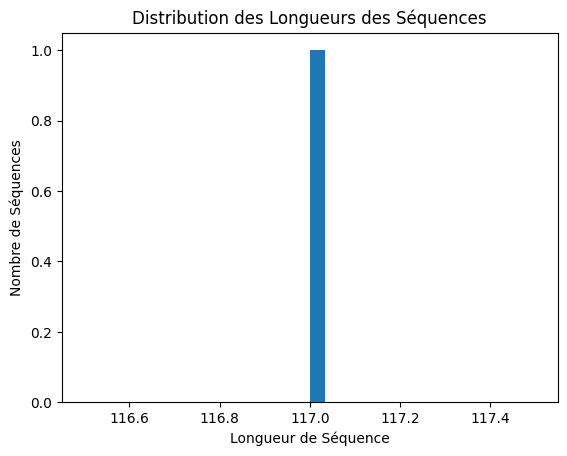

In [18]:
############ affichage longueur  max "balanced categorical feature"

mean_length = np.mean(max_sequence_length_balanced)
max_length = np.max(max_sequence_length_balanced)
min_length = np.min(max_sequence_length_balanced)
std_dev = np.std(max_sequence_length_balanced)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(max_sequence_length_balanced, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()

In [22]:
# Hyperparamètres et dimensions des données*
taille_num_features_balanced = scaled_df_balanced.shape[1]
taille_text_features_balanced = max_sequence_length_balanced   # je donne la taille max parmi les longueur des sequences 
embedding_dim = 256 #128  ## sa dimension ne doit pas depasser la valeur du [d_model dans l'encodeur] 

vocab_size = 2000
taille_num_features_imbalanced = scaled_df_imbalanced.shape[1]
taille_text_features_imbalanced = max_sequence_length_imbalanced   # je donne la taille max parmi les longueur des sequences 
embedding_dim = 256 

In [23]:
# Entrées

############## Balanced Model ####################

input_num = tf.keras.layers.Input(shape=(taille_num_features_balanced,))
input_text = tf.keras.layers.Input(shape=(taille_text_features_balanced,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)


# Branche textuelle - Embedding + LSTM
# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features_balanced)(input_text)

mask_inputs = masque_remplissage(input_text) 

num_blocks = 4
out_seq = text_branch  # Initialisation avec les embeddings
for _ in range(num_blocks):
    out_seq = Encodeur(
            n_layers=4,
            d_model=256, 
            num_heads=8,
            middle_units=256,
            max_seq_len=taille_text_features_balanced)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches 

# Fusion des branches 

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Dropout

# Couches supplémentaires après la fusion
merged = Dropout(0.5)(merged)
merged = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged) 

# Création et compilation du modèle

model_balanced = Model(inputs=[input_num, input_text], outputs=output)

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])

model_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model_balanced.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 117)]        0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 64)           896         ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 117, 256)     512000      ['input_4[0][0]']                
                                                                                              

In [24]:
# Entrées

############## ImBalanced Model ####################

input_num = tf.keras.layers.Input(shape=(taille_num_features_imbalanced,))
input_text = tf.keras.layers.Input(shape=(taille_text_features_imbalanced,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)


# Branche textuelle - Embedding + LSTM
# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features_imbalanced)(input_text)

mask_inputs = masque_remplissage(input_text) 

num_blocks = 4
out_seq = text_branch  # Initialisation avec les embeddings
for _ in range(num_blocks):
    out_seq = Encodeur(
            n_layers=4,
            d_model=256, 
            num_heads=8,
            middle_units=256,
            max_seq_len=taille_text_features_imbalanced)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches 

# Fusion des branches 

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Dropout

# Couches supplémentaires après la fusion
merged = Dropout(0.5)(merged)
merged = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged) 

# Création et compilation du modèle

model_imbalanced = Model(inputs=[input_num, input_text], outputs=output)

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])

model_imbalanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model_imbalanced.summary())



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 108)]        0           []                               
                                                                                                  
 dense_102 (Dense)              (None, 64)           896         ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 108, 256)     512000      ['input_6[0][0]']                
                                                                                            

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Entrées pour l'entraînement
data_num_balanced = scaled_df_balanced   
data_text_balanced = pad_sequences(tokens_balanced, maxlen=max_sequence_length_balanced,padding='post')

# Entrées pour l'entraînement
data_num_imbalanced = scaled_df_imbalanced  
data_text_imbalanced = pad_sequences(tokens_imbalanced, maxlen=max_sequence_length_imbalanced,padding='post')


In [32]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Encodage de la cible en labels numériques
label_encoder = LabelEncoder()
# print(y_balanced) [o=bengnin ,1=malicioux]
y_balanced_encoded = label_encoder.fit_transform(y_balanced)
print(y_balanced_encoded)
print(y_balanced_encoded.shape)

print("\n")

y_imbalanced_encoded = label_encoder.fit_transform(y_imbalanced)
print(y_imbalanced_encoded)
print(y_imbalanced_encoded.shape)


0        malicioux
1        malicioux
2        malicioux
3        malicioux
4        malicioux
           ...    
33006      bengnin
33007      bengnin
33008      bengnin
33009      bengnin
33010      bengnin
Name: class, Length: 33011, dtype: object
[1 1 1 ... 0 0 0]
(33011,)


[1 1 1 ... 0 0 0]
(413011,)


In [29]:
################# Balanced and Imbalanced #########################

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
balanced_text_train, balanced_text_test, balanced_num_train, balanced_num_test, balanced_labels_train, balanced_labels_test = train_test_split(
    data_text_balanced, data_num_balanced, y_balanced_encoded, test_size=0.2, random_state=42
)

imbalanced_text_train, imbalanced_text_test, imbalanced_num_train, imbalanced_num_test, imbalanced_labels_train, imbalanced_labels_test = train_test_split(
    data_text_imbalanced, data_num_imbalanced, y_imbalanced_encoded, test_size=0.2, random_state=42
)

In [30]:
print("Shape of text_train:", balanced_text_train.shape)
print("Shape of labels_train:", balanced_labels_train.shape)
print("Shape of text_test:", balanced_text_test.shape)
print("Shape of labels_test:", balanced_labels_test.shape)
print("Shape of num_train:", balanced_num_train.shape)
print("Shape of num_test:", balanced_num_test.shape)

print("Visualisation des dimension et du batch_size\n")

batch_size, dimension = balanced_text_train.shape[0], balanced_text_train.shape[1]
print("Batch size text train:", batch_size)
print("Dimension text train:", dimension)

batch_size, dimension = balanced_num_train.shape[0], balanced_num_train.shape[1]
print("Batch size num train:", batch_size)
print("Dimension num train:", dimension)



Shape of text_train: (26408, 117)
Shape of labels_train: (26408,)
Shape of text_test: (6603, 117)
Shape of labels_test: (6603,)
Shape of num_train: (26408, 13)
Shape of num_test: (6603, 13)
Visualisation des dimension et du batch_size

Batch size text train: 26408
Dimension text train: 117
Batch size num train: 26408
Dimension num train: 13


In [31]:
# Afficher quelques exemples des données d'entraînement
print("Exemples des données d'entraînement:")
print("Text_train:")
print(balanced_text_train[:5])
print("\nNum_train:")
print(balanced_num_train[:5])
print("\nLabels_train:")
print(balanced_labels_train[:5])

# Faire de même pour les données de test


# Vérifier si des valeurs nan sont présentes
print("\nVérification des valeurs nan:")
print("Text_train contains nan:", np.isnan(balanced_text_train).any())
print("Num_train contains nan:", np.isnan(balanced_num_train).any())
print("Labels_train contains nan:", np.isnan(balanced_labels_train).any())

# Faire de même pour les données de test



Exemples des données d'entraînement:
Text_train:
[[ 4 16 12 80 30 14 47 17 39 39 64 14 17 39 20 31  4  5  6 93  1 42  1 22
   3 59  1 24  1 51  1 38 21 27  1 18 84 10 54 57 44 25 28 23  2  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [13 41 16 15 12 43 26 20 19 31 37 47 39 53 66 76  4  7  9  8  5  6  3 24
   1 32  1 36  1 33  3 42  1 49  1 56 11 10 54 44  2  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4 41 72 73 22 16 15 12 43 26 95 30 17 31 17 47 17  4  7  9  8  5  6 93
   1 42  3 27  1 22 10 45 57 44 25 28 23  2  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0 

In [47]:
### Balanced 

history_balanced= model_balanced.fit([balanced_num_train,balanced_text_train], balanced_labels_train , epochs=10, batch_size=64, validation_data=([balanced_num_test,balanced_text_test],balanced_labels_test))


Train on 40124 samples, validate on 10032 samples
Epoch 1/10
40124/40124 [==============================] - ETA: 0s - loss: 1.1588 - accuracy: 0.4672

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40124/40124 [==============================] - 81s 2ms/sample - loss: 1.1588 - accuracy: 0.4672 - val_loss: 1.0689 - val_accuracy: 0.5166
Epoch 2/10
40124/40124 [==============================] - 76s 2ms/sample - loss: 1.0511 - accuracy: 0.5268 - val_loss: 1.0152 - val_accuracy: 0.5527
Epoch 3/10
40124/40124 [==============================] - 76s 2ms/sample - loss: 1.0031 - accuracy: 0.5530 - val_loss: 0.9807 - val_accuracy: 0.5670
Epoch 4/10
40124/40124 [==============================] - 78s 2ms/sample - loss: 0.9705 - accuracy: 0.5710 - val_loss: 0.9491 - val_accuracy: 0.5770
Epoch 5/10
40124/40124 [==============================] - 74s 2ms/sample - loss: 0.9531 - accuracy: 0.5824 - val_loss: 0.9353 - val_accuracy: 0.6006
Epoch 6/10
40124/40124 [==============================] - 75s 2ms/sample - loss: 0.9382 - accuracy: 0.5893 - val_loss: 0.9194 - val_accuracy: 0.6017
Epoch 7/10
40124/40124 [==============================] - 82s 2ms/sample - loss: 0.9253 - accuracy: 0.5949 - val_loss

In [ ]:
### ImBalanced 


history_imbalanced= model_imbalanced.fit([imbalanced_num_train,imbalanced_text_train], imbalanced_labels_train , epochs=10, batch_size=64, validation_data=([imbalanced_num_test,imbalanced_text_test],imbalanced_labels_test))


In [ ]:
#on effectue les prediction sur les donnees de test

y_pred_balanced = model_balanced.predict([balanced_num_test,balanced_text_test])

y_pred_imbalanced = model_imbalanced.predict([imbalanced_num_test,imbalanced_text_test])

# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner pqr lq fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred_balanced = np.round(y_pred_balanced)
y_pred_imbalanced = np.round(y_pred_imbalanced)
                    
### Evaluation
                             
evaluation_results_balanced = model_balanced.evaluate([balanced_num_test,balanced_text_test], balanced_labels_test)
evaluation_results_imbalanced = model_imbalanced.evaluate([imbalanced_num_test,imbalanced_text_test], imbalanced_labels_test)
# loss, accuracy = model.evaluate([num_test, text_test], labels_test)


# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Balanced Perte sur les données de test:", evaluation_results_balanced[0])
print("Balanced Précision sur les données de test:", evaluation_results_balanced[1])

print("  \n")

print("ImBalanced Perte sur les données de test:", evaluation_results_imbalanced[0])
print("ImBalanced Précision sur les données de test:", evaluation_results_imbalanced[1])



In [ ]:
from sklearn.metrics import classification_report,accuracy_score


# Afficher le rapport de classification
class_report_balanced = classification_report(balanced_labels_test, y_pred_balanced)
print("Balanced Rapport de classification :\n", class_report_balanced)

print(" \n")

class_report_imbalanced = classification_report(imbalanced_labels_test, y_pred_imbalanced)
print("Balanced Rapport de classification :\n", class_report_imbalanced)


In [ ]:
########## Balanced ########

# Extraction des métriques d'entraînement
loss = history_balanced.history['loss']
accuracy = history_balanced.history['accuracy']
val_loss = history_balanced.history['val_loss']
val_accuracy = history_balanced.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['loss'], label='Training loss')
plt.plot(history_balanced.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['accuracy'], label='Training accuracy')
plt.plot(history_balanced.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

In [ ]:
########## ImBalanced ########

# Extraction des métriques d'entraînement
loss = history_imbalanced.history['loss']
accuracy = history_imbalanced.history['accuracy']
val_loss = history_imbalanced.history['val_loss']
val_accuracy = history_imbalanced.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history_imbalanced.history['loss'], label='Training loss')
plt.plot(history_imbalanced.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history_imbalanced.history['accuracy'], label='Training accuracy')
plt.plot(history_imbalanced.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

In [ ]:
#### Balanced #######


#affichage de la matrixe de confusion

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix


#calul preliminaire pour obtenir la matrice de confusion

conf_matrix = confusion_matrix(balanced_labels_test,y_pred_balanced)
true_negatives, false_positives,false_negatives, true_positives = conf_matrix.ravel()

# Créer la matrice de confusion
conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# Afficher la matrice de confusion avec seaborn
df_cm = pd.DataFrame(conf_matrix, index=['Bengnin 0', 'Malicioux 1'], columns=['Bengnin 0', 'Malicioux 1'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de Confusion')
plt.show()


In [ ]:
#### Balanced #######


#affichage de la matrixe de confusion

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix


#calul preliminaire pour obtenir la matrice de confusion

conf_matrix = confusion_matrix(imbalanced_labels_test,y_pred_imbalanced)
true_negatives, false_positives,false_negatives, true_positives = conf_matrix.ravel()

# Créer la matrice de confusion
conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# Afficher la matrice de confusion avec seaborn
df_cm = pd.DataFrame(conf_matrix, index=['Bengnin 0', 'Malicioux 1'], columns=['Bengnin 0', 'Malicioux 1'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de Confusion')
plt.show()


In [ ]:
############################################ Marche tres bien ############
################################## En utilisant le BayesianOptimization() et le ModelChekpoint qui detient le meilleur model ] #######################


##### Hyper parametre Tuning
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.metrics import AUC


from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import BayesianOptimization




# Définir la fonction pour la recherche des hyperparamètres
def build_model(hp):
    model = Model(inputs=[input_num, input_text], outputs=output)

    # Définir les hyperparamètres à optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    hp_lstm_units = hp.Choice('lstm_units', values=[64, 128, 256])
    hp_dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    hp_embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 256])

    # Compiler le modèle avec les hyperparamètres
    # optimizer = Adam(lr=hp_learning_rate)

    optimizer = Adam(learning_rate=hp_learning_rate)

    # model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

#Pour resoudre les erreur 
import os

# Vérifier si le répertoire existe, sinon le créer
save_directory = 'my_dir'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Créer un tuner pour la recherche des hyperparamètres

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    hyperparameters=HyperParameters(),
    directory=save_directory,
    project_name='lstm_ffn_hyperparam_tuning'
)

# Définir un callback ModelCheckpoint pour sauvegarder le meilleur modèle
filepath=os.path.abspath('my_dir/lstm_ffn_hyperparam_tuning/best_model.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


# Rechercher les meilleurs hyperparamètres en utilisant les données d'entraînement et de validation
# Utiliser le callback BayesianOptimizationCallback

tuner.search([num_train, text_train], labels_train, epochs=5, validation_data=([num_test, text_test], labels_test), callbacks=[checkpoint_callback])

# Obtenir les meilleurs hyperparamètres trouvés
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best hyperparameters: {best_hps}")

# Réutiliser les meilleurs hyperparamètres pour construire le modèle final
model = build_model(best_hps)

# Entraîner le modèle avec les données complètes
model.fit([num_train, text_train], labels_train, epochs=5, batch_size=32, validation_data=([num_test, text_test], labels_test))


In [ ]:
################################################################


############################################ Marche tres bien ############
################################## En utilisant le BayesianOptimization() et le ModelChekpoint qui detient le meilleur model ] #######################


##### Hyper parametre Tuning ##############

# Définir la fonction pour la recherche des hyperparamètres
def build_model(hp):
    model = Model(inputs=[input_num, input_text], outputs=output)

    # Définir les hyperparamètres à optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    hp_lstm_units = hp.Choice('lstm_units', values=[64, 128, 256])
    hp_dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    hp_embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 256])

    # Compiler le modèle avec les hyperparamètres
    # optimizer = Adam(lr=hp_learning_rate)
    optimizer = Adam(learning_rate=hp_learning_rate)

    # model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model








# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

#Pour resoudre les erreur 
import os

# Vérifier si le répertoire existe, sinon le créer
save_directory = 'my_dir'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Créer un tuner pour la recherche des hyperparamètres

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    hyperparameters=HyperParameters(),
    directory=save_directory,
    project_name='lstm_ffn_hyperparam_tuning'
)


# Définir un callback ModelCheckpoint pour sauvegarder le meilleur modèle
filepath=os.path.abspath('my_dir/lstm_ffn_hyperparam_tuning/best_model.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


# Rechercher les meilleurs hyperparamètres en utilisant les données d'entraînement et de validation
# Utiliser le callback BayesianOptimizationCallback

tuner.search([num_train, text_train], labels_train, epochs=5, validation_data=([num_test, text_test], labels_test), callbacks=[checkpoint_callback])

# Obtenir les meilleurs hyperparamètres trouvés
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best hyperparameters: {best_hps}")

# Réutiliser les meilleurs hyperparamètres pour construire le modèle final
model = build_model(best_hps)

# Entraîner le modèle avec les données complètes
history = model.fit([num_train, text_train], labels_train, epochs=5, batch_size=32, validation_data=([num_test, text_test], labels_test))

